In [1]:
import os
import random
import requests
import time
from PIL import Image
import base64
import io
import json
import re
from tqdm import tqdm
import numpy as np

In [2]:
import csv
import random
import time
import json
import copy


import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = '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'
os.environ['LANGSMITH_PROJECT'] = 'pr-wooden-hedgehog-65'
os.environ['OPENAI_API_KEY'] = 'sk-g4MycviIFf8Lad0v5zVKPljDpueIDBLuqIC1nsDAiRnLZVKg'
os.environ['OPENAI_API_BASE'] = 'https://api2.aigcbest.top/v1'

from typing import Any, List, Dict

# LangChain 和 LangSmith 的相关导入
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ChatMessage

def generate_from_openai_chat_completion_new(
    messages: List[Dict[str, str]],
    model: str,
    temperature: float,
    max_tokens: int,
    top_p: float,
    context_length: int, # 这个参数在ChatOpenAI中不直接使用，但为了保持签名一致而保留
    stop_token: str | None = None,
) -> str:
    """
    使用 LangChain 的 ChatOpenAI 生成聊天回复，并支持 LangSmith 追踪。
    函数签名与旧版完全兼容。
    """
    if "OPENAI_API_KEY" not in os.environ and "api_key" not in locals():
        raise ValueError("OPENAI_API_KEY environment variable must be set.")

    # 1. 初始化 LangChain 的 ChatOpenAI 客户端
    # 将旧函数的参数映射到 ChatOpenAI 的构造函数中
    llm = ChatOpenAI(
        # 从环境变量获取 key 和 base_url，提供默认值
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url=os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1"),
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        stop=[stop_token] if stop_token else None,
        model_kwargs={}, # 如果没有其他高级参数，可以为空字典或直接省略
        # 内置重试机制，替代旧的装饰器
        max_retries=3,
    )

    # 2. 将输入的字典列表转换为 LangChain 的消息对象
    # 这是一个必要的适配步骤
    langchain_messages = []
    for msg in messages:
        role = msg.get("role")
        content = msg.get("content", "")
        # 从字典中获取 name，如果不存在则为 None
        name = msg.get("name")

        if role == "user":
            langchain_messages.append(HumanMessage(content=content, name=name))
        elif role == "assistant":
            langchain_messages.append(AIMessage(content=content, name=name))
        elif role == "system":
            # 这会正确处理您提供的 few-shot 示例
            langchain_messages.append(SystemMessage(content=content, name=name))
        else:
            # 为其他可能的角色（如 'tool'）提供一个通用处理
            langchain_messages.append(ChatMessage(role=role, content=content))

    # 3. 调用 LLM 并获取结果
    response = llm.invoke(langchain_messages)

    # 4. 提取并返回内容，保持与旧函数相同的字符串输出
    return response.content

In [43]:
# example_messages_with_name = [{
#     'role': 'user',
#     'content': "hello"
# }]

# result = generate_from_openai_chat_completion_new(
#     messages=example_messages_with_name,
#     model="gpt-4o",
#     temperature=0.7,
#     max_tokens=2000,
#     top_p=1.0,
#     context_length=4096,
#     stop_token=None
# )

In [3]:
system_prompt = """You are an expert in evaluating GUI agent task trajectories. Your task is to assess the quality and effectiveness of task trajectories for GUI manipulation tasks.

A trajectory consists of the following components:
1. High-level Instruction: Describes the user's intended task (e.g., "Create a new travel itinerary document in a folder").
2. Action History: Includes two key parts:
    - A web page's accessibility tree: A simplified representation of the webpage.
    - The executed action.

When evaluating a trajectory, consider these key aspects:

### Evaluation Criteria:
1. Trajectory Coherence:
   - Do the low-level steps and corresponding actions follow a logical sequence toward the goal?
   - Are the actions clearly described and specific?
   - Are there redundant or unnecessary actions?

2. Task Completion:
   - Does the trajectory successfully achieve the instructed task?
   - Are all necessary interactions completed?
   - Are error cases handled appropriately?

### Scoring Guidelines:
Rate the trajectory on a scale of 1 to 5 based on the evaluation criteria:

- 5: The task is perfectly completed, successfully executing multiple actions to achieve the goal. The sequence is logically clear with no noticeable redundancies.
- 4: The task is mostly completed, successfully executing multiple actions. However, due to challenges or ambiguities in the instructions, the completion is not perfect, or there are inefficiencies in the process.
- 3: The task is partially completed, with some successful actions executed. However, due to task or environmental constraints, the goal is not fully achieved, or the sequence ends in a loop or error.
- 2: Only a few actions are executed. Although there is an attempt to complete the task, the trajectory deviates from the goal early on or demonstrates significant inefficiencies in execution and logic.
- 1: The task fails completely, with no meaningful actions executed at the start. The sequence either falls into an immediate deadlock, a repetitive loop, or demonstrates no value in completing the task.

Note: If the task is relatively complex, but the trajectory demonstrates valuable attempts, even if the task is not fully completed, consider adjusting the score upward. However, if the task is complex but the trajectory fails to perform actions that contribute meaningfully to task completion, no extra points should be awarded.

### Response Format:
Format your response into two lines as shown below: 
Reason: <your thoughts and reasoning process for the score>
Score: <your score from 1-5>
"""

In [4]:
def format_user_input_string(traj):
    ret = ""

    instruction_line = ""
    split_lines = traj[0]['conversations'][0]['value'].split("\n")
    for line in split_lines:
        if line.startswith("Instruction:"):
            instruction_line = line
            break
    
    if instruction_line == "":
        raise ValueError("Instruction line not found")
    ret += instruction_line + "\n" + f"=============round{1}================\n\n"

    
    for i in range(len(traj)):
        split_lines = traj[i]['conversations'][0]['value'].split("\n")
        a_11y_lines = []
        a_11y_start_flg = False
        for line in split_lines:
            if line.startswith("Accessibility tree:"):
                a_11y_start_flg = True
            elif line.startswith("Action History:"):
                a_11y_start_flg = False


            if a_11y_start_flg:
                a_11y_lines.append(line)

        ret += "\n".join(a_11y_lines) + "\n\n"
        ret += "Action: " + traj[i]['conversations'][1]['value'] + "\n\n"

        if i != len(traj) - 1:
            ret += f"=============round{i+2}================\n\n"
    
    return ret


In [46]:
import csv

result_csv_path = "/home/zjusst/qms/osgensis/rating.csv"
if not os.path.exists(result_csv_path):
    with open(result_csv_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["json_file_path", "reason", "score"])


In [ ]:
json_dir_path = "/home/zjusst/qms/osgensis/len_5_trajs"
json_file_paths = os.listdir(json_dir_path)

for json_file_path in tqdm(json_file_paths):
    with open(f"{json_dir_path}/{json_file_path}", "r") as f:
        traj = json.load(f)
    
    user_input_string = format_user_input_string(traj)
    example_messages_with_name = [{
            'role': 'system',
            'content': system_prompt
        }, 
        {
            'role': 'user',
            'content': user_input_string
        }
    ]

    result = generate_from_openai_chat_completion_new(
        messages=example_messages_with_name,
        model="gpt-4o",
        temperature=0.5,
        max_tokens=1500,
        top_p=0.9,
        context_length=4096,
        stop_token=None
    )

    reason = ""
    score = ""
    result_lines = result.split("\n")
    for line in result_lines:
        if line.startswith("Reason:"):
            reason = line.split(":")[1].strip()
        elif line.startswith("Score:"):
            score = line.split(":")[1].strip()
    
    if not reason or not score:
        raise ValueError("Reason or score not found")

    with open(result_csv_path, "a") as f:
        writer = csv.writer(f)
        writer.writerow([f"{json_dir_path}/{json_file_path}", reason, score])


  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
print(example_messages_with_name[1]['content'])

Instruction: Check the contributions made by the user on May 20, 2024, and summarize the type of activities (e.g., issues, merge requests, or comments) if any are found.
=============round1================

Accessibility tree: Tab 0 (current): Projects · Dashboard · GitLab

[1] RootWebArea 'Projects · Dashboard · GitLab' focused: True
	[211] link 'Skip to content'
	[332] link 'Dashboard'
	[407] button '' hasPopup: menu expanded: False
	[1591] textbox 'Search GitLab' required: False
	[1552] generic 'Use the shortcut key <kbd>/</kbd> to start a search'
	[414] link 'Create new...'
	[416] link 'Issues'
		[1161] generic '13 assigned issues'
	[417] link 'Merge requests'
		[1163] generic '8 merge requests'
	[419] link 'To-Do List'
	[420] link 'Help'
	[422] link 'Byte Blaze'
		[1213] img 'Byte Blaze'
	[7] main ''
		[314] heading 'Projects'
		[317] link 'New project'
		[424] link 'Yours 15'
		[425] link 'Starred 4'
		[426] link 'Explore'
		[427] link 'Topics'
		[324] searchbox 'Filter by name'


In [48]:
print(result)

Reason: The trajectory demonstrates a logical sequence of actions that effectively complete the task. Initially, the agent correctly identifies and clicks on the 'Electronics' link to navigate to the relevant section. Upon reaching the 'Electronics' section, the agent understands the need to scroll down to find the subcategories and their item counts. Finally, the agent successfully retrieves and lists all available subcategories along with the number of items in each, achieving the task's objective without any unnecessary actions or errors.

Score: 5


In [ ]:
# 读取 /home/zjusst/qms/osgensis/rating.csv
rating_csv_path = "/home/zjusst/qms/osgensis/rating.csv"
with open(rating_csv_path, "r") as f:
    reader = csv.reader(f)
    # 跳过第一行
    next(reader)
    rating_data = [row for row in reader]

traj_len_to_rating_data = {}
for row in rating_data:
    traj_len = row[0].split("/")[-2].split("_")[1]
    if traj_len not in traj_len_to_rating_data:
        traj_len_to_rating_data[traj_len] = []
    traj_len_to_rating_data[traj_len].append(row)

traj_len_to_score_data = {}
for traj_len in ['2', '3', '4', '5']:
    #print(len(traj_len_to_rating_data[traj_len]))
    traj_len_to_score_data[traj_len] = []
    for row in traj_len_to_rating_data[traj_len]:
        traj_len_to_score_data[traj_len].append(row[2])

# traj_len_to_score_data['5']

['3',
 '3',
 '5',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '3',
 '5',
 '3',
 '5',
 '5',
 '5',
 '5',
 '3',
 '1',
 '5',
 '5',
 '5',
 '2',
 '3',
 '5']

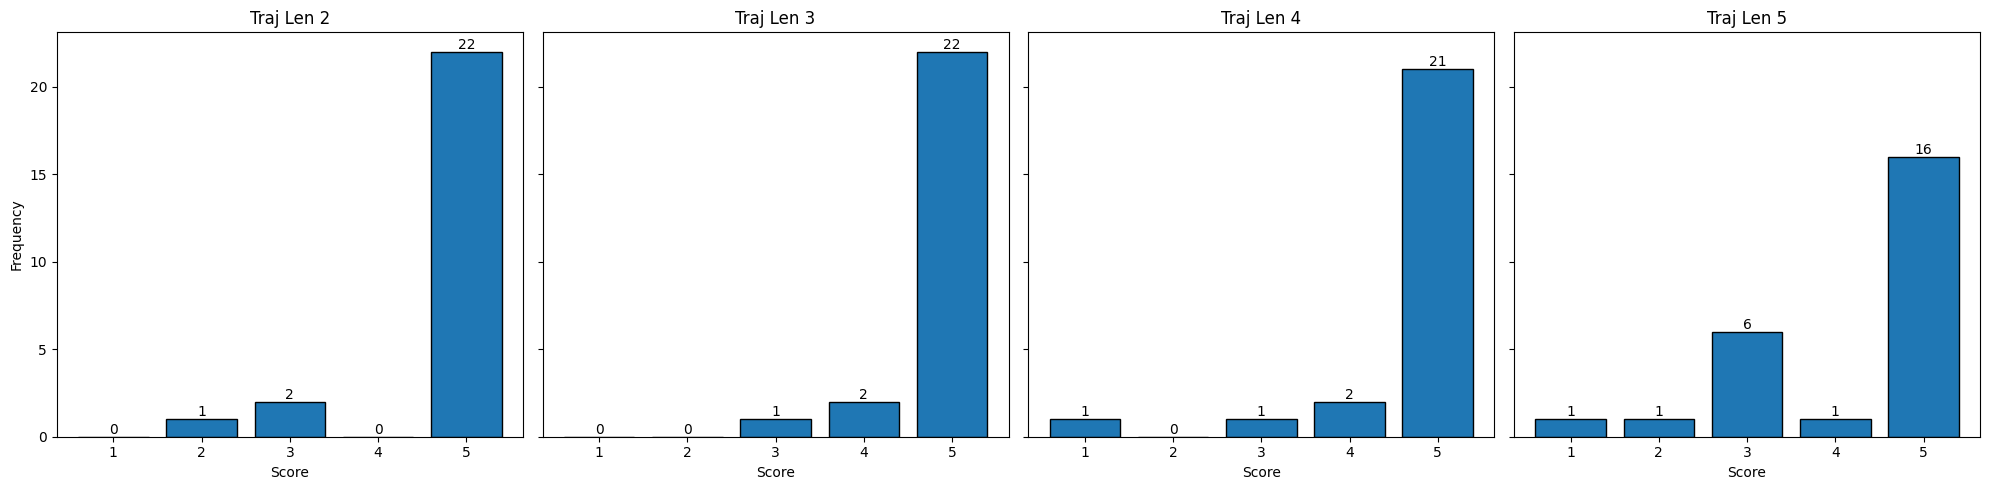

In [64]:
# 绘图，统计每个长度的评分分布
import matplotlib.pyplot as plt

# 统计每个长度的评分分布，柱子上标上数量
# 四个图作为四个子图画在同一个画布上
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
traj_lens = ['2', '3', '4', '5']
for idx, traj_len in enumerate(traj_lens):
    data = traj_len_to_score_data[traj_len]
    counts = {}
    for score in ['1', '2', '3', '4', '5']:
        counts[score] = data.count(score)
    scores = list(counts.keys())
    freq = list(counts.values())

    bars = axs[idx].bar(scores, freq, edgecolor='black')
    axs[idx].set_title(f'Traj Len {traj_len}')
    axs[idx].set_xlabel('Score')
    if idx == 0:
        axs[idx].set_ylabel('Frequency')
    # 在柱子上标上数量
    for bar, count in zip(bars, freq):
        axs[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()
